# Experimenting with LDA

This notebook contains some of the very simple experiments with existing LDA implementations from `gensim` library.

**Author:** Eemeli Saari

**Created:** 10.3.2019

**Edited:** 14.3.2019

---

In [1]:
import os
import sys
import collections
import itertools

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora.dictionary import Dictionary

c:\users\eemeli\documents\projects\keytopicdetection\.env\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
sys.path.append('../detector/')

In [5]:
from corpora import Corpora

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
data_path = ''

In [245]:
YEAR = 2013

In [8]:
with Corpora(os.path.join(data_path, f'CVPR{YEAR}')) as corp:
    tokens = corp.tokens

Following the example from [gensim.LdaMulticore](https://radimrehurek.com/gensim/models/ldamulticore.html)

In [9]:
%time dictionary = Dictionary(tokens)

Wall time: 1.98 s


In [10]:
%time corpus = [dictionary.doc2bow(text) for text in tokens]

Wall time: 1.79 s


In [61]:
N_TOPICS = 150

In [14]:
%time lda = LdaMulticore(corpus, num_topics=N_TOPICS, passes=50, iterations=500, id2word=dictionary)

c:\users\eemeli\documents\projects\keytopicdetection\.env\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Wall time: 18min 37s


In [363]:
lda.save('lda_cvpr_2013')

In [364]:
lda = LdaMulticore.load('lda_cvpr_2013')

In [16]:
data = collections.defaultdict(list)

### Extracting the topics

Here we simply extract the topics for the whole conference.

More elegant methods would include summing for each document for yeah year computing the probas from that.

In [29]:
%time doc_topics = lda.get_document_topics(dictionary.doc2bow(itertools.chain(*tokens)), minimum_probability=0)

Wall time: 2.4 s


In [289]:
words = []
for topic in lda.show_topics(num_topics=N_TOPICS, num_words=15):
    words.append([x.split('*')[1].strip().replace('"', '') for x in topic[1].split('+')])

In [298]:
lda.num_topics

150

In [308]:
word_df = pd.DataFrame(np.array(words).T)

In [309]:
word_df.to_csv('cvpr2013_topics_N150.csv')

In [181]:
for i, dist in sorted(doc_topics, key=lambda x: x[1], reverse=True):
    print(f'Topic {i} with top words: {", ".join([(lda.id2word[index]) for index, proba in lda.get_topic_terms(i, topn=8)])}')

Topic 132 with top words: cid, sampl, imag, method, gener, column, base, model
Topic 94 with top words: set, featur, stage, train, imag, method, cascad, local
Topic 47 with top words: model, variabl, problem, method, energi, algorithm, pairwis, optim
Topic 138 with top words: region, imag, color, salienc, pixel, background, salient, method
Topic 114 with top words: segment, class, imag, region, pixel, featur, label, dataset
Topic 116 with top words: cid, imag, blur, camera, depth, motion, estim, method
Topic 19 with top words: cid, imag, method, problem, model, set, approach, base
Topic 13 with top words: video, action, activ, recognit, tempor, featur, human, represent
Topic 56 with top words: imag, featur, match, correspond, visual, word, queri, idf
Topic 42 with top words: video, frame, motion, object, tempor, segment, scene, move
Topic 101 with top words: detect, pedestrian, detector, model, approach, dataset, window, multi
Topic 122 with top words: class, sampl, categori, cid, trai

Topic 17 with top words: video, cid, event, level, descript, concept, dataset, model
Topic 89 with top words: word, object, visual, topic, cid, video, model, occurr
Topic 105 with top words: cid, map, psf, local, function, data, otf, model
Topic 125 with top words: shape, object, registr, deform, rigid, reconstruct, cue, method
Topic 98 with top words: imag, color, model, boundari, repres, visual, detect, oppon
Topic 62 with top words: cid, distanc, graph, similar, pair, median, point, chromosom
Topic 95 with top words: object, featur, shadow, light, camera, imag, correspond, figur
Topic 36 with top words: segment, label, neg, silhouett, error, video, object, voxel
Topic 107 with top words: train, stm, classiﬁ, object, approach, test, weight, person
Topic 140 with top words: imag, object, featur, propos, transform, salienc, approach, method
Topic 21 with top words: rai, light, probe, ga, path, camera, pattern, cid
Topic 58 with top words: map, area, surfac, method, comput, brain, prese

In [69]:
data = {i:0.0 for i in range(N_TOPICS)}

In [74]:
topic_data = dict(doc_topics)

In [71]:
data.update(topic_data)

## Visualization

Here are some of the visualizations that can be obtained from the topics

In [7]:
style.use('ggplot')

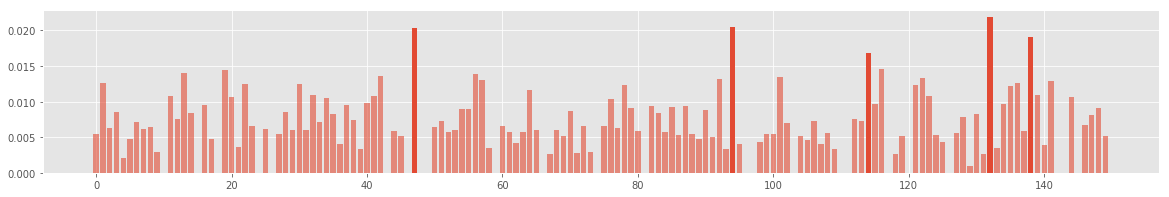

In [190]:
fig, ax = plt.subplots(figsize=(20,3))
ax.bar(data.keys(), data.values(), alpha=0.6)
rects = ax.patches
for i in sorted(data, key=lambda k: data[k], reverse=True)[:5]:
    rects[i].set_alpha(1)

One interesting factor that occured when feeding the data from a single year was that some of the topics are not present. Maybe it should be adviced to use something similar to Hall et al. 2008.

In [231]:
doc_topics = lda.get_document_topics(corpus, minimum_probability=0)

In [232]:
topics_numpy = np.array(doc_topics)

In [ ]:
lda.corpus2topic()

In [205]:
topics_numpy.shape

(471, 150, 2)

In [342]:
topics_numpy[:,:,1].shape

(471, 150)

Resulting matrix is of shape: (documents, n_topics, (id, proba))

In [234]:
(topics_numpy[:,:,1].sum(axis=0)/topics_numpy.shape[0]).sum()

1.0000000004468874

In [ ]:
topic_by_doc = topics_numpy[:,:,1].sum(axis=0)/topics_numpy.shape[0]

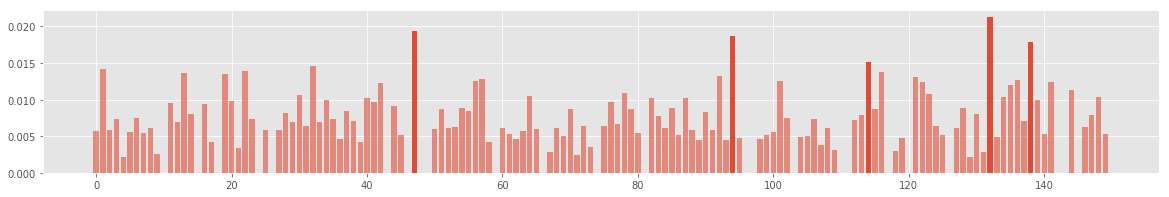

In [227]:
fig, ax = plt.subplots(figsize=(20,3))
ax.bar(range(N_TOPICS), topic_by_doc, alpha=0.6)
rects = ax.patches
for i in np.argsort(topic_by_doc)[-5:]:
    rects[i].set_alpha(1)

It's hard to detect the differences but by plotting the on top of each other we can detect it better.

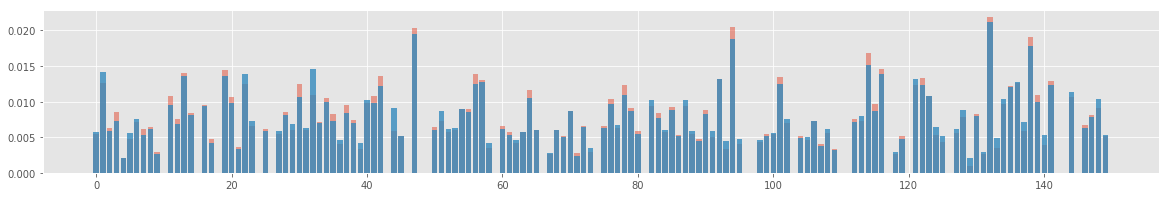

In [267]:
fig, ax = plt.subplots(figsize=(20,3))
ax.bar(data.keys(), data.values(), alpha=0.5)
ax.bar(range(N_TOPICS), topic_by_doc, alpha=0.8)
plt.show()

## Storing the results

The topics should then be stored to somewhere for further usage.

In [249]:
id2doc = os.listdir(os.path.join(data_path, f'CVPR{YEAR}'))

In [254]:
stats = pd.DataFrame(topics_numpy[:,:,1], columns=[f'Topic{i}' for i in range(topics_numpy.shape[1])])
doc_year = pd.DataFrame([(YEAR, id2doc[i]) for i in range(topics_numpy.shape[0])], columns=['year', 'doc'])

In [263]:
df = stats.merge(doc_year, how='outer', right_index=True, left_index=True)

In [265]:
df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic142,Topic143,Topic144,Topic145,Topic146,Topic147,Topic148,Topic149,year,doc
0,1.927716e-03,1.581364e-03,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,...,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,6.228784e-07,2013,Abrams_The_Episolar_Constraint_2013_CVPR_paper...
1,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,...,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,4.804808e-07,2013,Agrawal_Single_Image_Calibration_2013_CVPR_pap...
2,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,...,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,5.183630e-07,2013,Akata_Label-Embedding_for_Attribute-Based_2013...
3,4.477578e-07,4.477578e-07,4.477578e-07,4.477578e-07,4.477578e-07,4.477578e-07,4.477578e-07,7.642050e-01,4.477578e-07,4.477578e-07,...,4.477578e-07,4.477578e-07,4.477578e-07,4.477578e-07,7.012030e-02,4.477578e-07,4.477578e-07,4.477578e-07,2013,Anderson_Expressive_Visual_Text-to-Speech_2013...
4,1.332268e-06,1.332268e-06,1.332268e-06,5.229267e-03,1.332268e-06,1.332268e-06,1.332268e-06,1.332268e-06,1.332268e-06,1.332268e-06,...,1.332268e-06,1.332268e-06,1.332268e-06,1.332268e-06,2.245850e-03,1.332268e-06,1.332268e-06,1.332268e-06,2013,Angelova_Efficient_Object_Detection_2013_CVPR_...
5,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,...,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,5.182825e-07,2.536768e-03,5.182825e-07,5.182825e-07,2013,Antunes_A_Global_Approach_2013_CVPR_paper.txt
6,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,...,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,4.492666e-07,2013,Arandjelovic_All_About_VLAD_2013_CVPR_paper.txt
7,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,...,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,4.615207e-07,2013,Arteta_Learning_to_Detect_2013_CVPR_paper.txt
8,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,...,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,5.322263e-07,1.243464e-02,5.322263e-07,5.322263e-07,2013,Asafi_Constraints_as_Features_2013_CVPR_paper.txt
9,8.703220e-07,6.345693e-01,8.703220e-07,8.703220e-07,8.703220e-07,4.965373e-04,8.703220e-07,8.703220e-07,8.703220e-07,8.703220e-07,...,8.703220e-07,8.703220e-07,8.703220e-07,8.703220e-07,8.703220e-07,8.703220e-07,8.703220e-07,8.703220e-07,2013,Ask_Optimal_Geometric_Fitting_2013_CVPR_paper.txt


In [307]:
lda.get_topics().shape

(150, 38412)

It is useful to store the full data instead of one topic distribution per year if for example we want to use the data to find interesting articles later on.

## Problems

Certainly the pdf parsing and the preprocessing can have impact on the topics.

For example the `pdfminer` used early on did not perform as good as expected thus maybe the `pdftotext` should be used instead. It has seemed to perform a lot better especially for not cutting the words from automatic pdf formatted texts.

The default gensim preprocessing also might cause problems since it does the word stemming that most of the papers don't do.